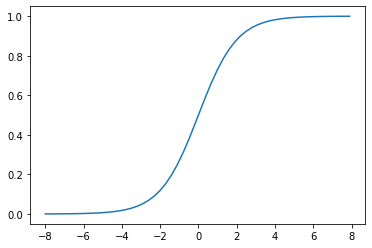

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#增加神经网络的非线性能力，跟relu之类的功能相似，激活作用
def sigmod(x):
    return 1./(1.+np.exp(-x))

x = np.arange(-8,8,0.3)
y = sigmod(x)
plt.plot(x,y)
plt.show()

In [8]:
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 加载数据
    datafile = './db/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')

    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == 'train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode == 'valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode == 'eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")

    #校验数据
    imgs_length = len(imgs)
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    # 定义数据集每个数据的序号， 根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的batchsize
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            # 在使用卷积神经网络结构时，uncomment 下面两行代码
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('float32')
            
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [2]:
import paddle.nn.functional as F
from paddle.nn import Linear
import paddle

#经典的全连接网络
class MNIST(paddle.nn.Layer):
        def __init__(self):
            super(MNIST,self).__init__()
             # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
            self.fc1 = Linear(in_features=784, out_features=10)
            self.fc2 = Linear(in_features=10, out_features=10)
            # 定义一层全连接输出层，输出维度是1
            self.fc3 = Linear(in_features=10, out_features=1)
            
        def forward(self,inputs):
            outputs1 = self.fc1(inputs)
            outputs1 = F.sigmoid(outputs1)
            outputs2 = self.fc2(outputs1)
            outputs2 = F.sigmoid(outputs2)
            outputs_final = self.fc3(outputs2)
            return outputs_final

In [11]:
#多层卷积神经网络
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是1
         self.fc = Linear(in_features=980, out_features=1)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层不使用激活函数
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x
        


In [15]:
def train(model):
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置为0.01
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # 训练5轮
    EPOCH_NUM = 10
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, loss))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list

model = MNIST()
loss_list = train(model)

loading mnist dataset from ./db/mnist.json.gz ......
mnist dataset load done
epoch: 0, batch: 0, loss is: 13.014755249023438
epoch: 0, batch: 200, loss is: 3319.310302734375
epoch: 0, batch: 400, loss is: 7.011143684387207
epoch: 1, batch: 0, loss is: 8.807613372802734
epoch: 1, batch: 200, loss is: 8.218161582946777
epoch: 1, batch: 400, loss is: 8.739236831665039
epoch: 2, batch: 0, loss is: 9.2091064453125
epoch: 2, batch: 200, loss is: 8.440081596374512
epoch: 2, batch: 400, loss is: 8.593708038330078
epoch: 3, batch: 0, loss is: 8.886415481567383
epoch: 3, batch: 200, loss is: 8.809117317199707
epoch: 3, batch: 400, loss is: 8.276765823364258
epoch: 4, batch: 0, loss is: 7.781915187835693
epoch: 4, batch: 200, loss is: 10.279857635498047
epoch: 4, batch: 400, loss is: 8.649367332458496
epoch: 5, batch: 0, loss is: 9.08138370513916
epoch: 5, batch: 200, loss is: 8.401537895202637
epoch: 5, batch: 400, loss is: 8.526601791381836
epoch: 6, batch: 0, loss is: 7.369721412658691
epoch: 

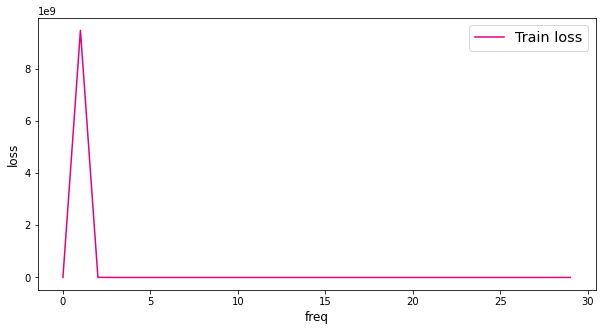

In [14]:
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    freqs = [i for i in range(len(loss_list))]
    # 绘制训练损失变化曲线
    plt.plot(freqs, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("freq", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)

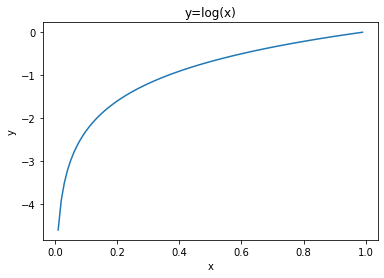

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
#损失函数
import matplotlib.pyplot as plt
import numpy as np
#arrang 生成步距范围，d,d1,步距为0.01
x = np.arange(0.01,1,0.01)
y = np.log(x)
plt.title("y=log(x)") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y)
plt.show()
plt.figure()

In [20]:
#交叉熵 逻辑
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 创建一个类MnistDataset，继承paddle.io.Dataset 这个类
# MnistDataset的作用和上面load_data()函数的作用相同，均是构建一个迭代器
class MnistDataset(paddle.io.Dataset):
    def __init__(self, mode):
        datafile = './db/mnist.json.gz'
        data = json.load(gzip.open(datafile))
        # 读取到的数据区分训练集，验证集，测试集
        train_set, val_set, eval_set = data
        
        # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
        self.IMG_ROWS = 28
        self.IMG_COLS = 28

        if mode=='train':
            # 获得训练数据集
            imgs, labels = train_set[0], train_set[1]
        elif mode=='valid':
            # 获得验证数据集
            imgs, labels = val_set[0], val_set[1]
        elif mode=='eval':
            # 获得测试数据集
            imgs, labels = eval_set[0], eval_set[1]
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'eval']")
        
        # 校验数据
        imgs_length = len(imgs)
        assert len(imgs) == len(labels), \
            "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
        
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        # img = np.array(self.imgs[idx]).astype('float32')
        # label = np.array(self.labels[idx]).astype('int64')
        img = np.reshape(self.imgs[idx], [1, self.IMG_ROWS, self.IMG_COLS]).astype('float32')
        label = np.reshape(self.labels[idx], [1]).astype('int64')

        return img, label

    def __len__(self):
        return len(self.imgs)
# 声明数据加载函数，使用训练模式，MnistDataset构建的迭代器每次迭代只返回batch=1的数据
train_dataset = MnistDataset(mode='train')
# 使用paddle.io.DataLoader 定义DataLoader对象用于加载Python生成器产生的数据，
# DataLoader 返回的是一个批次数据迭代器，并且是异步的；
train_loader = paddle.io.DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
val_dataset = MnistDataset(mode='valid')
val_loader = paddle.io.DataLoader(val_dataset, batch_size=128,drop_last=True)

In [21]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         return x

In [22]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.extend(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean
#仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）
def train(model):
    model.train()
    #调用加载数据的函数
    # train_loader = load_data('train')
    # val_loader = load_data('valid')
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
        # acc_train_mean = evaluation(model, train_loader)
        # acc_val_mean = evaluation(model, val_loader)
        # print('train_acc: {}, val acc: {}'.format(acc_train_mean, acc_val_mean))   
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

epoch: 0, batch: 0, loss is: [3.6796272]
epoch: 0, batch: 200, loss is: [0.25459313]
epoch: 0, batch: 400, loss is: [0.30347252]
epoch: 1, batch: 0, loss is: [0.23477112]
epoch: 1, batch: 200, loss is: [0.10130489]
epoch: 1, batch: 400, loss is: [0.15087089]
epoch: 2, batch: 0, loss is: [0.13562942]
epoch: 2, batch: 200, loss is: [0.0669746]
epoch: 2, batch: 400, loss is: [0.10961614]
epoch: 3, batch: 0, loss is: [0.11192314]
epoch: 3, batch: 200, loss is: [0.05438013]
epoch: 3, batch: 400, loss is: [0.07421029]
epoch: 4, batch: 0, loss is: [0.0624933]
epoch: 4, batch: 200, loss is: [0.04010511]
epoch: 4, batch: 400, loss is: [0.10596585]
epoch: 5, batch: 0, loss is: [0.07662383]
epoch: 5, batch: 200, loss is: [0.07813232]
epoch: 5, batch: 400, loss is: [0.0405609]
epoch: 6, batch: 0, loss is: [0.07298713]
epoch: 6, batch: 200, loss is: [0.13342337]
epoch: 6, batch: 400, loss is: [0.03344295]
epoch: 7, batch: 0, loss is: [0.07590066]
epoch: 7, batch: 200, loss is: [0.07107726]
epoch: 7

In [32]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = 'db/9.png'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
tensor_img = load_image(img_path)
#模型反馈10个分类标签的对应概率
results = model(paddle.to_tensor(tensor_img))
#取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())
print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  4


In [ ]:
#目标检测 oL
#卷积 convolotion
Hout = H+pw1+sph-kh+1


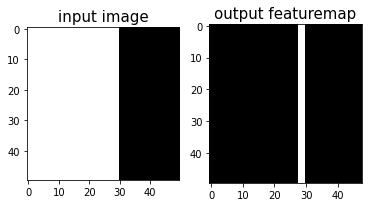

Parameter containing:
Tensor(shape=[1, 1, 1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[[ 1.,  0., -1.]]]])
Parameter containing:
Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [0.])


In [33]:
#简单的边缘检测
import matplotlib.pyplot as plt
import numpy as np
import paddle
from paddle.nn import Conv2D
from paddle.nn.initializer import Assign
%matplotlib inline

# 创建初始化权重参数w
w = np.array([1, 0, -1], dtype='float32')
# 将权重参数调整成维度为[cout, cin, kh, kw]的四维张量
w = w.reshape([1, 1, 1, 3])
# 创建卷积算子，设置输出通道数，卷积核大小，和初始化权重参数
# kernel_size = [1, 3]表示kh = 1, kw=3
# 创建卷积算子的时候，通过参数属性weight_attr指定参数初始化方式
# 这里的初始化方式时，从numpy.ndarray初始化卷积参数
conv = Conv2D(in_channels=1, out_channels=1, kernel_size=[1, 3],
       weight_attr=paddle.ParamAttr(
          initializer=Assign(value=w)))

# 创建输入图片，图片左边的像素点取值为1，右边的像素点取值为0
img = np.ones([50,50], dtype='float32')
img[:, 30:] = 0.
# 将图片形状调整为[N, C, H, W]的形式
x = img.reshape([1,1,50,50])
# 将numpy.ndarray转化成paddle中的tensor
x = paddle.to_tensor(x)
# 使用卷积算子作用在输入图片上
y = conv(x)
# 将输出tensor转化为numpy.ndarray
out = y.numpy()
f = plt.subplot(121)
f.set_title('input image', fontsize=15)
plt.imshow(img, cmap='gray')
f = plt.subplot(122)
f.set_title('output featuremap', fontsize=15)
# 卷积算子Conv2D输出数据形状为[N, C, H, W]形式
# 此处N, C=1，输出数据形状为[1, 1, H, W]，是4维数组
# 但是画图函数plt.imshow画灰度图时，只接受2维数组
# 通过numpy.squeeze函数将大小为1的维度消除
plt.imshow(out.squeeze(), cmap='gray')
plt.show()
# 查看卷积层的权重参数名字和数值
print(conv.weight)
# 参看卷积层的偏置参数名字和数值
print(conv.bias)

In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import paddle
from paddle.nn import Conv2D
from paddle.nn.initializer import Assign
img = Image.open('./db/airplane.png')

# 设置卷积核参数
w = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype='float32')/8
w = w.reshape([1, 1, 3, 3])
# 由于输入通道数是3，将卷积核的形状从[1,1,3,3]调整为[1,3,3,3]
w = np.repeat(w, 3, axis=1)
# 创建卷积算子，输出通道数为1，卷积核大小为3x3，
# 并使用上面的设置好的数值作为卷积核权重的初始化参数
conv = Conv2D(in_channels=3, out_channels=1, kernel_size=[3, 3], 
            weight_attr=paddle.ParamAttr(
              initializer=Assign(value=w)))
    
# 将读入的图片转化为float32类型的numpy.ndarray
x = np.array(img).astype('float32')
# 图片读入成ndarry时，形状是[H, W, 3]，
# 将通道这一维度调整到最前面
x = np.transpose(x, (2,0,1))
# 将数据形状调整为[N, C, H, W]格式
x = x.reshape(1, 3, img.height, img.width)
x = paddle.to_tensor(x)
y = conv(x)
out = y.numpy()
plt.figure(figsize=(20, 10))
f = plt.subplot(121)
f.set_title('input image', fontsize=15)
plt.imshow(img)
f = plt.subplot(122)
f.set_title('output feature map', fontsize=15)
plt.imshow(out.squeeze(), cmap='gray')
plt.show()

ValueError: cannot reshape array of size 771144 into shape (1,3,381,506)